In [21]:
import sys
import os
sys.path.append("..")  # Adds the parent directory to the sys.path

from utitlity_functions import *
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
import cv2 as cv
from matplotlib import cm
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw
from hough_circle_trafo import hough_circle
from confectionery import Confectionery
import seaborn_image as isns
from matplotlib.ticker import MaxNLocator
import matplotlib
from matplotlib.patches import Patch
from scipy.stats import multivariate_normal
plt.rcdefaults()
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 11,
    'text.usetex': True,
})
from sklearn.cluster import KMeans
np.random.seed(137)




In [22]:
im_paths=np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/Janus_Particle_Tracking_long_video/data/Gute_aufnahme_shortened/image_paths.npy")

In [23]:
im_0=cv.imread("../"+im_paths[0],cv.IMREAD_GRAYSCALE)
height,width=im_0.shape
mask_scale=np.ones(im_0.shape,dtype=np.bool_)
mask_scale[1953:height-5,1700:width-5]=0
mask_scale[5:24,1941:width-6]=0


A=np.zeros_like(im_0)
A[mask_scale==0]=im_0[mask_scale==0]
scale_values_original=cv.cvtColor(A,cv.COLOR_GRAY2RGB)

In [24]:
X=np.array([cv.GaussianBlur(cv.imread("../"+x,cv.IMREAD_GRAYSCALE).astype(np.float32),ksize=(3,3),sigmaX=0) for x in im_paths[:200]])
X=np.transpose(X,axes=[1,2,0])


In [25]:
test_im=X[:,:,140].reshape((height,width))

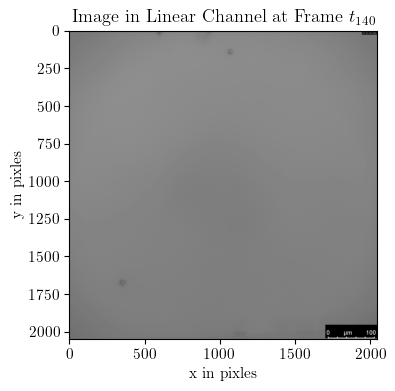

In [26]:
fig=plt.figure()
fig.set_size_inches(10,4) 
ax = fig.gca()
plt.rcParams["figure.figsize"] = (10,4)
plt.title("Image in Linear Channel at Frame $t_{140}$")
plt.xlabel("x in pixles")
plt.ylabel("y in pixles")
plt.imshow(test_im, cmap="gray")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/k_means_image.eps', format="eps", dpi=1200, bbox_inches="tight")

In [27]:
data=test_im[mask_scale==1].reshape((-1,1))
K=2
kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(data)
labels=kmeans.labels_.reshape((-1))
means=kmeans.cluster_centers_.reshape((-1))

In [28]:
test_im=test_im.reshape((-1,1))
d1=np.linalg.norm(test_im-means[0],axis=1)
d2=np.linalg.norm(test_im-means[1],axis=1)

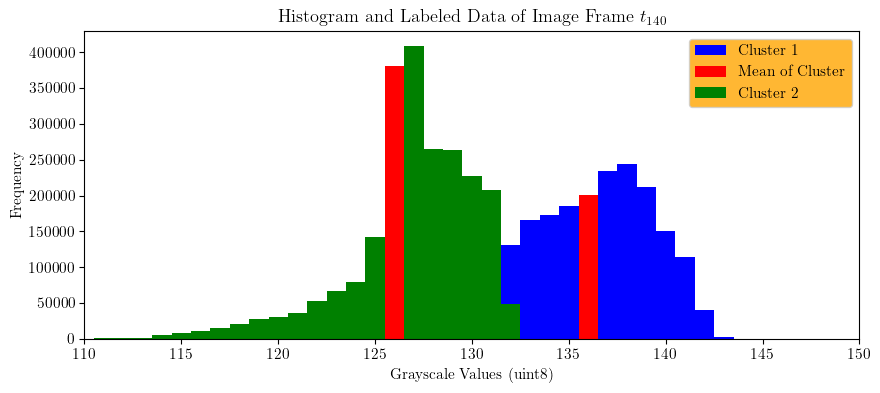

In [29]:
index_label_1=d1<=d2
index_label_2=d1>d2
scale_label=mask_scale.reshape(-1)==0
index_label_1=np.logical_and(index_label_1,scale_label==0)
index_label_2=np.logical_and(index_label_2,scale_label==0)

Y1=test_im[index_label_1,0]
Y2=test_im[index_label_2,0]

bins=np.arange(0,257)-0.5

index=np.zeros(K,dtype=int)
for i in range(K):
    index[i]=np.where((bins>means[i]))[0][0]-2

fig=plt.figure()
fig.set_size_inches(10,4) 
ax = fig.gca()
plt.title("Histogram and Labeled Data of Image Frame $t_{140}$")
counts, __, patches = plt.hist(Y1, bins=bins, histtype='bar',color="blue", label="Cluster 1")
for i in range(K):
    patches[index[i]].set_fc('r')
plt.hist(counts[index[0]], bins=bins[index[0]:index[0]+2], histtype='bar',color="red", label="Mean of Cluster")
counts, __, patches = plt.hist(Y2, bins=bins, histtype='bar',color="green", label="Cluster 2")

for i in range(K):
    patches[index[i]].set_fc('r')
plt.xlabel("Grayscale Values (uint8)")
plt.ylabel("Frequency")
plt.xlim(110, 150)
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/k_means_image_hist.eps', format="eps", dpi=1200, bbox_inches="tight")

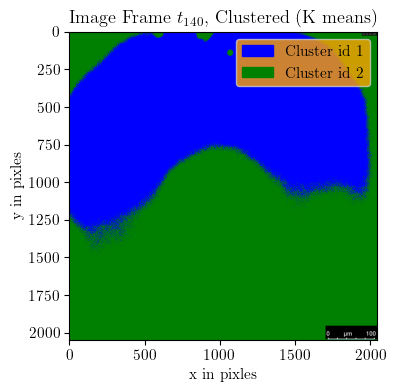

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [30]:
Im_labeled=scale_values_original#np.zeros((height,width,3),dtype=np.uint8)
blue=np.array([0,0,255]).reshape((1,1,3))
green=np.array([0,128,0]).reshape((1,1,3))
colors=[blue, green]
a=np.arange(test_im.size)
labels=[index_label_1,index_label_2]
for i in range(K):
    b=a[labels[i]]
    index=np.unravel_index(b, (height,width))
    Im_labeled[index[0],index[1],:]=colors[i]


fig=plt.figure()
fig.set_size_inches(10,4) 
plt.title("Image Frame $t_{140}$, Clustered (K means)")
plt.xlabel("x in pixles")
plt.ylabel("y in pixles")
blue_patch = mpatches.Patch(color='blue', label='Cluster id 1')
green_patch = mpatches.Patch(color='green', label='Cluster id 2')
plt.legend(handles=[blue_patch, green_patch],frameon=True, facecolor="orange")
plt.imshow(Im_labeled)
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/k_means_image_labels.eps', format="eps", dpi=1200, bbox_inches="tight")